<a href="https://colab.research.google.com/github/andrewcxjin/aipi590-xai/blob/main/explainable_deep_learning_Jin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Explainable Deep Learning**

**Andrew Jin**

This notebook will apply GradCAM and two of its variants to an image classification problem.

Dataset: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition/data

I will be using a dataset that has images of fruits and vegetables. The motivation comes from a personal problem where I have a history of stomach issues so I have to be cautious of my diet. Addtionally, having lived in 3 different countries I have noticed that fresh produce in the USA tends to go bad the fastest. If image classification can successfully identify fruits and vegetables from a picture, then we may be able to do further analysis with these images to gain more insights.

#### 📝 Note
My Colab has a built in assistant from Gemini that provided small suggestions on the code such as parameters. Any block of code that were generated from ChatGPT will be cited right under it. All other code were generated by myself with the help of papers and documentation about libraries.

Additional References:

https://jacobgil.github.io/pytorch-gradcam-book/introduction.html

https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/


In [1]:
!pip install torch torchvision timm grad-cam ttach

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=e196d816389bdd28223d7a74cea96479718fb3a7a0999004282ab12b4cfe08f3
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import random
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
import torch
import torchvision

### Dataset and Model Preparation

In [9]:
# Download dataset from Kaggle
import kagglehub

path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")

100%|██████████| 1.98G/1.98G [00:27<00:00, 77.2MB/s]

Extracting files...


In [10]:
# Transform data to fit ResNet50 parameters
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [11]:
# Separate dataset
train_dataset = datasets.ImageFolder(root=path + '/train', transform=transform)
test_dataset = datasets.ImageFolder(root=path + '/test', transform=transform)
val_dataset = datasets.ImageFolder(root=path + '/validation', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [34]:
# Download ImageNet labels
!wget -q https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
imagenet_classes = [line.strip() for line in open('imagenet_classes.txt')]
# The above 2 lines of code were generated using ChatGPT on 10/03/25 at 10:28p

In [36]:
# Load pretrained model and construct CAM objects
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]

cam = GradCAM(model=model, target_layers=target_layers)
score_cam = ScoreCAM(model=model, target_layers=target_layers)
eigen_cam = EigenCAM(model=model, target_layers=target_layers)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Image 1

In [ ]:
# Select random image from test set
idx = random.randint(0, len(test_dataset)-1)
img_tensor, label = test_dataset[idx]
input_tensor = img_tensor.unsqueeze(0).to(device)

# Transform image back to original for visualization
img_orig = img_tensor.cpu().permute(1,2,0).numpy()
img_orig = (img_orig * np.array([0.229,0.224,0.225])) + np.array([0.485,0.456,0.406])
img_orig = np.clip(img_orig, 0, 1)
# The above 3 lines of code were generated using ChatGPT on 10/03/25 at 10:52p

# Prediction
with torch.no_grad():
    outputs = model(input_tensor)
    pred_class = outputs.argmax(dim=1).item()
    pred_label = imagenet_classes[pred_class]

targets = [ClassifierOutputTarget(pred_class)]

# Run GradCAM and variants, and overlay image
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img_orig, grayscale_cam, use_rgb=True)

grayscale_eigen = eigen_cam(input_tensor=input_tensor, targets=targets)
grayscale_eigen = grayscale_eigen[0, :]
visualization_eigen = show_cam_on_image(img_orig, grayscale_eigen, use_rgb=True)

grayscale_score = score_cam(input_tensor=input_tensor, targets=targets)
grayscale_score = grayscale_score[0, :]
visualization_score = show_cam_on_image(img_orig, grayscale_score, use_rgb=True)

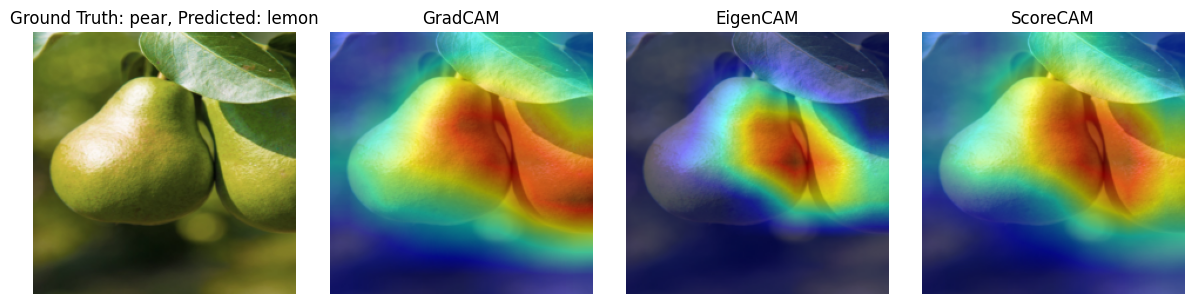

In [47]:
# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(img_orig)
axes[0].set_title(f"Ground Truth: {test_dataset.classes[label]}, Predicted: {pred_label}")
axes[0].axis('off')
axes[1].imshow(visualization)
axes[1].set_title("GradCAM")
axes[1].axis('off')
axes[2].imshow(visualization_eigen)
axes[2].set_title("EigenCAM")
axes[2].axis('off')
axes[3].imshow(visualization_score)
axes[3].set_title("ScoreCAM")
axes[3].axis('off')
plt.tight_layout()
plt.show()

### Image 2

In [48]:
# Select random image from test set
idx = random.randint(0, len(test_dataset)-1)
img_tensor, label = test_dataset[idx]
input_tensor = img_tensor.unsqueeze(0).to(device)

# Transform image back to original for visualization
img_orig = img_tensor.cpu().permute(1,2,0).numpy()
img_orig = (img_orig * np.array([0.229,0.224,0.225])) + np.array([0.485,0.456,0.406])
img_orig = np.clip(img_orig, 0, 1)
# The above 3 lines of code were generated using ChatGPT on 10/03/25 at 10:52p

# Prediction
with torch.no_grad():
    outputs = model(input_tensor)
    pred_class = outputs.argmax(dim=1).item()
    pred_label = imagenet_classes[pred_class]

targets = [ClassifierOutputTarget(pred_class)]

# Run GradCAM and variants, and overlay image
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img_orig, grayscale_cam, use_rgb=True)

grayscale_eigen = eigen_cam(input_tensor=input_tensor, targets=targets)
grayscale_eigen = grayscale_eigen[0, :]
visualization_eigen = show_cam_on_image(img_orig, grayscale_eigen, use_rgb=True)

grayscale_score = score_cam(input_tensor=input_tensor, targets=targets)
grayscale_score = grayscale_score[0, :]
visualization_score = show_cam_on_image(img_orig, grayscale_score, use_rgb=True)

100%|██████████| 128/128 [06:52<00:00,  3.22s/it]


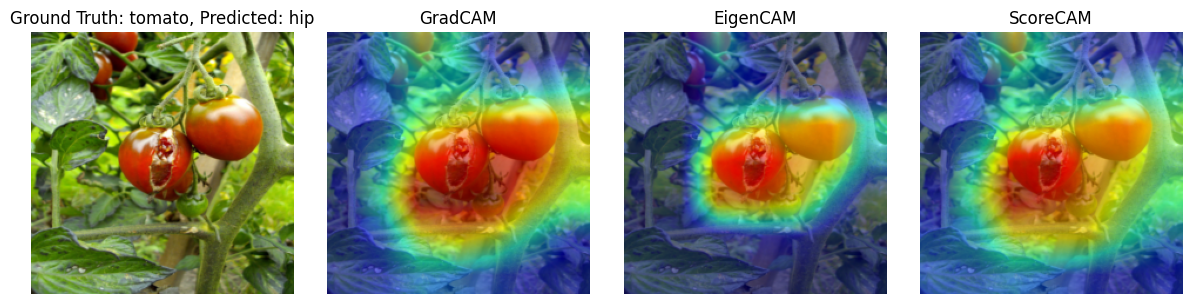

In [49]:
# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(img_orig)
axes[0].set_title(f"Ground Truth: {test_dataset.classes[label]}, Predicted: {pred_label}")
axes[0].axis('off')
axes[1].imshow(visualization)
axes[1].set_title("GradCAM")
axes[1].axis('off')
axes[2].imshow(visualization_eigen)
axes[2].set_title("EigenCAM")
axes[2].axis('off')
axes[3].imshow(visualization_score)
axes[3].set_title("ScoreCAM")
axes[3].axis('off')
plt.tight_layout()
plt.show()

### Image 3

In [50]:
# Select random image from test set
idx = random.randint(0, len(test_dataset)-1)
img_tensor, label = test_dataset[idx]
input_tensor = img_tensor.unsqueeze(0).to(device)

# Transform image back to original for visualization
img_orig = img_tensor.cpu().permute(1,2,0).numpy()
img_orig = (img_orig * np.array([0.229,0.224,0.225])) + np.array([0.485,0.456,0.406])
img_orig = np.clip(img_orig, 0, 1)
# The above 3 lines of code were generated using ChatGPT on 10/03/25 at 10:52p

# Prediction
with torch.no_grad():
    outputs = model(input_tensor)
    pred_class = outputs.argmax(dim=1).item()
    pred_label = imagenet_classes[pred_class]

targets = [ClassifierOutputTarget(pred_class)]

# Run GradCAM and variants, and overlay image
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img_orig, grayscale_cam, use_rgb=True)

grayscale_eigen = eigen_cam(input_tensor=input_tensor, targets=targets)
grayscale_eigen = grayscale_eigen[0, :]
visualization_eigen = show_cam_on_image(img_orig, grayscale_eigen, use_rgb=True)

grayscale_score = score_cam(input_tensor=input_tensor, targets=targets)
grayscale_score = grayscale_score[0, :]
visualization_score = show_cam_on_image(img_orig, grayscale_score, use_rgb=True)

100%|██████████| 128/128 [06:32<00:00,  3.06s/it]


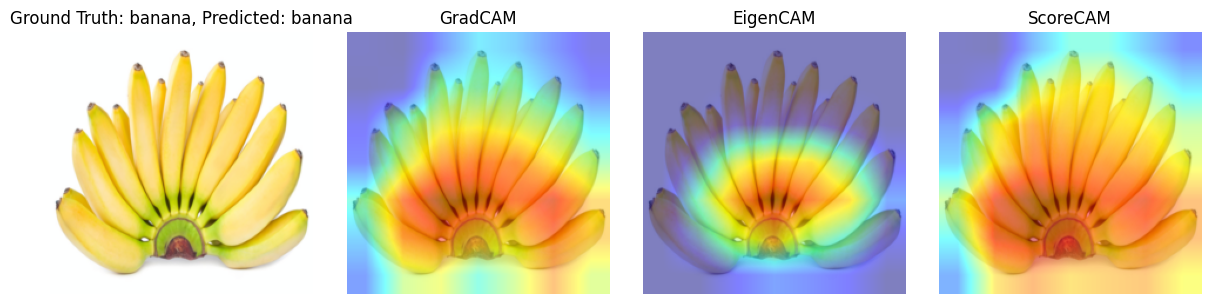

In [51]:
# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(img_orig)
axes[0].set_title(f"Ground Truth: {test_dataset.classes[label]}, Predicted: {pred_label}")
axes[0].axis('off')
axes[1].imshow(visualization)
axes[1].set_title("GradCAM")
axes[1].axis('off')
axes[2].imshow(visualization_eigen)
axes[2].set_title("EigenCAM")
axes[2].axis('off')
axes[3].imshow(visualization_score)
axes[3].set_title("ScoreCAM")
axes[3].axis('off')
plt.tight_layout()
plt.show()

### Image 4

In [52]:
# Select random image from test set
idx = random.randint(0, len(test_dataset)-1)
img_tensor, label = test_dataset[idx]
input_tensor = img_tensor.unsqueeze(0).to(device)

# Transform image back to original for visualization
img_orig = img_tensor.cpu().permute(1,2,0).numpy()
img_orig = (img_orig * np.array([0.229,0.224,0.225])) + np.array([0.485,0.456,0.406])
img_orig = np.clip(img_orig, 0, 1)
# The above 3 lines of code were generated using ChatGPT on 10/03/25 at 10:52p

# Prediction
with torch.no_grad():
    outputs = model(input_tensor)
    pred_class = outputs.argmax(dim=1).item()
    pred_label = imagenet_classes[pred_class]

targets = [ClassifierOutputTarget(pred_class)]

# Run GradCAM and variants, and overlay image
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img_orig, grayscale_cam, use_rgb=True)

grayscale_eigen = eigen_cam(input_tensor=input_tensor, targets=targets)
grayscale_eigen = grayscale_eigen[0, :]
visualization_eigen = show_cam_on_image(img_orig, grayscale_eigen, use_rgb=True)

grayscale_score = score_cam(input_tensor=input_tensor, targets=targets)
grayscale_score = grayscale_score[0, :]
visualization_score = show_cam_on_image(img_orig, grayscale_score, use_rgb=True)

100%|██████████| 128/128 [06:35<00:00,  3.09s/it]


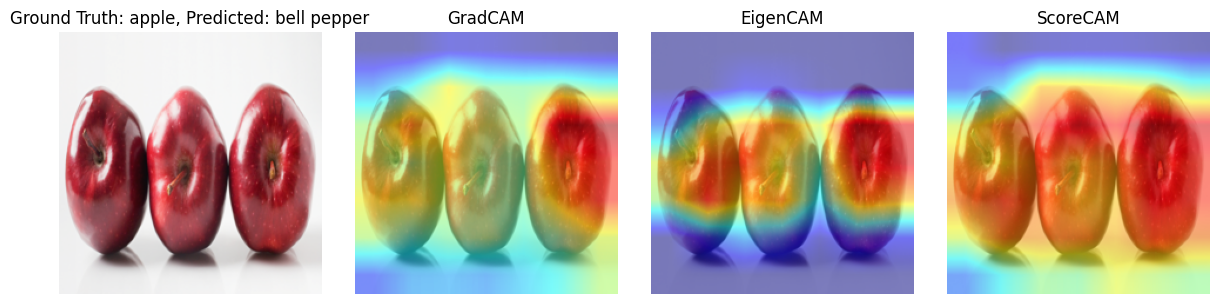

In [53]:
# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(img_orig)
axes[0].set_title(f"Ground Truth: {test_dataset.classes[label]}, Predicted: {pred_label}")
axes[0].axis('off')
axes[1].imshow(visualization)
axes[1].set_title("GradCAM")
axes[1].axis('off')
axes[2].imshow(visualization_eigen)
axes[2].set_title("EigenCAM")
axes[2].axis('off')
axes[3].imshow(visualization_score)
axes[3].set_title("ScoreCAM")
axes[3].axis('off')
plt.tight_layout()
plt.show()

### Image 5

In [54]:
# Select random image from test set
idx = random.randint(0, len(test_dataset)-1)
img_tensor, label = test_dataset[idx]
input_tensor = img_tensor.unsqueeze(0).to(device)

# Transform image back to original for visualization
img_orig = img_tensor.cpu().permute(1,2,0).numpy()
img_orig = (img_orig * np.array([0.229,0.224,0.225])) + np.array([0.485,0.456,0.406])
img_orig = np.clip(img_orig, 0, 1)
# The above 3 lines of code were generated using ChatGPT on 10/03/25 at 10:52p

# Prediction
with torch.no_grad():
    outputs = model(input_tensor)
    pred_class = outputs.argmax(dim=1).item()
    pred_label = imagenet_classes[pred_class]

targets = [ClassifierOutputTarget(pred_class)]

# Run GradCAM and variants, and overlay image
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img_orig, grayscale_cam, use_rgb=True)

grayscale_eigen = eigen_cam(input_tensor=input_tensor, targets=targets)
grayscale_eigen = grayscale_eigen[0, :]
visualization_eigen = show_cam_on_image(img_orig, grayscale_eigen, use_rgb=True)

grayscale_score = score_cam(input_tensor=input_tensor, targets=targets)
grayscale_score = grayscale_score[0, :]
visualization_score = show_cam_on_image(img_orig, grayscale_score, use_rgb=True)

100%|██████████| 128/128 [06:31<00:00,  3.06s/it]


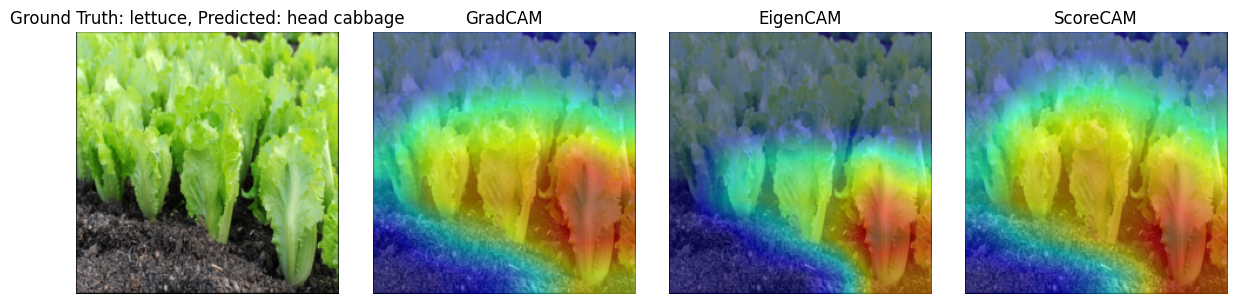

In [55]:
# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(img_orig)
axes[0].set_title(f"Ground Truth: {test_dataset.classes[label]}, Predicted: {pred_label}")
axes[0].axis('off')
axes[1].imshow(visualization)
axes[1].set_title("GradCAM")
axes[1].axis('off')
axes[2].imshow(visualization_eigen)
axes[2].set_title("EigenCAM")
axes[2].axis('off')
axes[3].imshow(visualization_score)
axes[3].set_title("ScoreCAM")
axes[3].axis('off')
plt.tight_layout()
plt.show()

### Analysis and Reflection

I chose a dataset with images of fruits and vegetables because of personal problem I was interested in. Image classification for fresh produce can improve efficiency and safety in the food industry, so that we as customers can enjoy them. Some potential applications could be identifying diseases, giving suggestions on shelter life, harvesting recommendations, and so on.

In this notebook, a pretrained ResNet50 model was chosen and the GradCAM, EigenCAM, and ScoreCAM were implemented to see which features of the images the model focuses on for its predictions. Note that the pretrained ResNet50 model uses only labels avaiable in the ImageNet 1000 Class List. Not all the fruits and vegetables from the Kaggle dataset are available in the ImageNet List so there are some unexpected predictions. Despite this, we can still evaluate how the model pays attention to the images. GradCAM uses the gradients of the traget class in the last convolutional layer. EigenCAM does a principal component analysis (PCA) so it helps us understand the unsupervised learning to see where the model would pay attention to with no labels. ScoreCAM uses activation maps to perturb features of the image to see which ones the model rely heavily on. GradCAM and ScoreCAM will tell us the important regions for a class label while EigenCAM will tell us generally where the model is looking. If we compare these three variants, the differences and similarities can tell us about how the model makes it predictions and whether it's reliable.  

From images 1-4, we can see that GradCAM, EigenCAM, and ScoreCAM all seem to focus on the same features as the red region is focused in the same area. For all of the images, the EigenCAM visualization has the smallest and most focused red region. The fact that GradCAM and ScoreCAM also focus on the same region shows that there is consistency in the most important feature as each variant of CAM evaluates feature importance in a different manner.

The result that surprised me the most is image 1 where the prediction was a lemon instead of the ground truth of a pear. The ImageNet list, however, did not have pear listed which explains the discrepancy. What I was surprised by was the feature that the model was giving most attention to. The original image contains two pears that overlap slightly. All CAM visualizations showed that most attention was given to the overlap region. The EigenCAM narrowed the red region to a specific region that seemed to be the shadow from the overlap. I expected the important feature to be the body or the shape of the fruit, but not the shadow from two fruits overlapping. Thus, I'm curious to see what the GradCAM results would be if there were only to be one pear.

Similarly, I am also curious to see how the results would be different for image 3 if there was only one banana instead of a bunch. The model predicted the fruit correctly, but the EigenCAM again showed a focused attention on the crown and neck of the bananas. If we were to only show one banana, would all the attention also be on the crown and neck or other areas?

The last image had an incorrect prediction as lettuce was not in the ImageNet list, but it was interesting to see how the red region highlighted one whole lettuce out of the bunch. I thought that it would highlight a specific region of the lettuce such as the stem or leaves. This makes me wonder how a model could differentiate between types of lettuce and other leafy vegebatles that look similar.

I also found it interesting that for image 4, each CAM variant seem to have different attention maps where for the other images all variants seem to gravitate towards the same features and regions. The GradCAM seemed to focus on one apple, the EigenCAM on two apples, and the ScoreCAM on all three apples. But it was reassuring to see that they all focused on the same stem region for the apples that they focused on.

The tomatoes in image 2 seemed to be rotting and since tomato is not in the ImageNet list, it made an incorrect prediction as expected. The GradCAM and its variants showed that the model focused on the rotten region. While this may not be the ideal feature to focus on while predicting a type of fruit or vegetable, this could be extremely useful in disease classification.

Overall, the GradCAM implementation showed very diverse and interesting results on how the ResNet50 model made its prediction. With further improvements, this could have significant benefits for the food industry. As mentioned in the tomato example, food diseases could be detected beforehand so that it doesn't accidentally end up on the shelves in grocery stores. Additionally, it could help those with dietary restrictions or allergies if they are having trouble figuring identifying the food. For those focused on their calorie intake, image classification could also help them keep track of their diet. Often times, grocery stores sell fresh produce by the weight that has to be manually done, so by implementing image classification this process could be automated and save time.